<a href="https://colab.research.google.com/github/k22sunil/Reliance_Stock_Prediction/blob/main/reliance_stock_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Relaince stock machine learning realtime##

In [ ]:
import yfinance as yf
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU
from datetime import datetime

# Function to fetch data
def fetch_stock_data(ticker_symbol, start_date="2020-01-01"):
    today = datetime.today().strftime('%Y-%m-%d')
    data = yf.download(ticker_symbol, start=start_date, end=today)
    data['Target'] = data['Close'].shift(-1)  # Predict next day's closing price
    return data.dropna()

# Function to preprocess data
def preprocess_data(data):
    X = data[['Open', 'High', 'Low', 'Close', 'Volume']].values
    y = data['Target'].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    return X_train, X_test, y_train, y_test

# Define models
def evaluate_models(X_train, X_test, y_train, y_test):
    results = {}

    # SVR
    svr = SVR(kernel='rbf')
    svr.fit(X_train, y_train)
    results['SVR'] = mean_squared_error(y_test, svr.predict(X_test))

    # Random Forest
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    results['Random Forest'] = mean_squared_error(y_test, rf.predict(X_test))

    # KNN
    knn = KNeighborsRegressor(n_neighbors=5)
    knn.fit(X_train, y_train)
    results['KNN'] = mean_squared_error(y_test, knn.predict(X_test))

    # LSTM
    X_train_lstm = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test_lstm = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    model_lstm = Sequential([
        LSTM(50, activation='relu', input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
        Dense(1)
    ])
    model_lstm.compile(optimizer='adam', loss='mse')
    model_lstm.fit(X_train_lstm, y_train, epochs=10, batch_size=32, verbose=0)
    results['LSTM'] = mean_squared_error(y_test, model_lstm.predict(X_test_lstm).flatten())

    # GRU
    model_gru = Sequential([
        GRU(50, activation='relu', input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
        Dense(1)
    ])
    model_gru.compile(optimizer='adam', loss='mse')
    model_gru.fit(X_train_lstm, y_train, epochs=10, batch_size=32, verbose=0)
    results['GRU'] = mean_squared_error(y_test, model_gru.predict(X_test_lstm).flatten())

    return results

# Main function to run evaluation
def run_pipeline(ticker_symbol):
    data = fetch_stock_data(ticker_symbol)
    X_train, X_test, y_train, y_test = preprocess_data(data)
    results = evaluate_models(X_train, X_test, y_train, y_test)
    best_model = min(results, key=results.get)
    print("\nModel Performances:")
    for model, mse in results.items():
        print(f"{model}: MSE = {mse:.4f}")
    print(f"\nBest Model: {best_model} with MSE = {results[best_model]:.4f}")

# Run the pipeline for RELIANCE.NS
run_pipeline("RELIANCE.NS")


[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

Model Performances:
SVR: MSE = 22063.3661
Random Forest: MSE = 403.6216
KNN: MSE = 585.9130
LSTM: MSE = 3277.1965
GRU: MSE = 1680.5481

Best Model: Random Forest with MSE = 403.6216


In [ ]:
import pickle

# Save the model
with open("random_forest_reliance_model.pkl", "wb") as file:
    pickle.dump(rf, file)

# Load the model for predictions
with open("random_forest_reliance_model.pkl", "rb") as file:
    loaded_model = pickle.load(file)

# Make predictions on new data
new_data = X_test[0].reshape(1, -1)  # Example new data
predicted_price = loaded_model.predict(new_data)
print(f"Predicted Price: {predicted_price[0]}")


Predicted Price: 1256.6349645996095


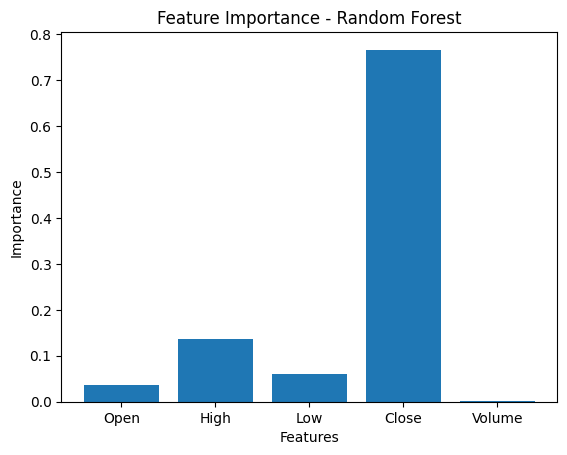

In [ ]:
import matplotlib.pyplot as plt

# Get feature importance
features = ['Open', 'High', 'Low', 'Close', 'Volume']
importances = rf.feature_importances_

# Plot feature importance
plt.bar(features, importances)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Feature Importance - Random Forest")
plt.show()


In [ ]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform Grid Search
grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best MSE: {-grid_search.best_score_}")


Best Parameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
Best MSE: 386.5336272268931


In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Train the optimized Random Forest model
optimized_rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=10,
    min_samples_leaf=4,
    min_samples_split=2,
    random_state=42
)

optimized_rf.fit(X_train, y_train)

# Evaluate on the test data
y_pred_optimized = optimized_rf.predict(X_test)
optimized_mse = mean_squared_error(y_test, y_pred_optimized)

print(f"Optimized Random Forest MSE: {optimized_mse:.4f}")


Optimized Random Forest MSE: 380.1645


In [ ]:
import pickle

# Save the optimized model
with open("optimized_random_forest_reliance.pkl", "wb") as file:
    pickle.dump(optimized_rf, file)

# Load the model for future use
with open("optimized_random_forest_reliance.pkl", "rb") as file:
    loaded_optimized_model = pickle.load(file)

# Predict with the loaded model
new_data = X_test[0].reshape(1, -1)
predicted_price = loaded_optimized_model.predict(new_data)
print(f"Predicted Price: {predicted_price[0]}")


Predicted Price: 1258.4579546414416
